In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import lab4_hmc as hmc

In [2]:
df_train = pd.read_csv('ee-train.csv')
df_test = pd.read_csv('ee-test.csv')

In [3]:
X_train = np.array(df_train.iloc[:, :-1])
y_train = np.array(df_train.iloc[:, -1])
X_test = np.array(df_test.iloc[:, :-1])
y_test = np.array(df_test.iloc[:, -1])

scaler = StandardScaler() # Standardise input variables

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
### EXAMPLES
def e_func(x, f):
    # Simulating some unknown log-probability
    p0 = -x[0]**2/2
    p1 = -x[1]**2/2 + np.log(2+np.cos(f*x[1]))
    lgp = p0 + p1
    return -lgp

def e_grad(x, f):
    g = np.empty(2)
    g[0] = x[0]
    g[1] = x[1] + f*np.sin(f*x[1]) / (2+np.cos(f*x[1]))
    return g

### Define Functions Here

In [5]:
# ### p(t|sigma_n_2, sigma_w_2)

# # X is observation data, x is hyperparameter set sigma_w_2 and sigma_n_2

# def compute_log_marginal(x, X, t): # p(t|sigma_n_2, sigma_w_2)
#     sigma_w_2 = x[0]
#     sigma_n_2 = x[1]
#     N = X.shape[0]
#     cov = sigma_n_2*np.eye(N) + sigma_w_2*X@X.T
#     return stats.multivariate_normal.logpdf(t, mean=None, cov=cov, allow_singular=True)

# # log uniform prior for both hyperparameters as they are scale parameters
# def e_func(x, X, t):
#     sigma_w_2 = x[0]
#     sigma_n_2 = x[1]
#     lgp = compute_log_marginal(x, X, t) + np.log(sigma_w_2) + np.log(sigma_n_2)
#     return -lgp # -ve log prob

# def e_grad(x, X, t):
#     sigma_w_2 = x[0]
#     sigma_n_2 = x[1]
#     N = X.shape[0]
#     cov = sigma_n_2*np.eye(N) + sigma_w_2*X@X.T
#     cov_inv = np.linalg.inv(cov)
#     deriv_w = X@X.T
#     deriv_n = np.eye(N)
    
#     grad_0 = t.T@cov_inv@deriv_w@cov_inv@t.T / 2 - np.trace(cov_inv@deriv_w) / 2 + 1/sigma_w_2
#     grad_1 = t.T@cov_inv@deriv_n@cov_inv@t.T / 2 - np.trace(cov_inv@deriv_n) / 2 + 1/sigma_n_2
    
#     return np.array([-grad_0, -grad_1])

In [6]:
# ### P*(w, sigma_w, sigma_n)

# def e_func(x, X, t):
#     w = x[:8]
#     sigma_w_2 = x[8]
#     sigma_n_2 = x[9]
#     N = X.shape[0]
#     M = X.shape[1]
    
#     lgp = -(N/2)*np.log(2*np.pi*sigma_n_2) - np.sum((t-X@w)**2)/(2*sigma_n_2) - \
#     (M/2)*np.log(2*np.pi*sigma_w_2) - np.sum(w**2)/(2*sigma_w_2) + \
#     np.log(sigma_w_2) + np.log(sigma_n_2)
    
#     return -lgp

# def e_grad(x, X, t):
#     w = x[:8]
#     sigma_w_2 = x[8]
#     sigma_n_2 = x[9]
#     N = X.shape[0]
#     M = X.shape[1]
#     grad = np.empty(10)
    
#     for i, w_i in enumerate(w):
#         grad[i] = -np.sum(X[:,i]*w_i)/sigma_n_2 - (w_i/sigma_w_2)
        
#     grad[8] = -M/(4*np.pi*sigma_w_2) + np.sum(w**2)/(2*sigma_w_2**2) + 1/sigma_w_2
#     grad[9] = -N/(4*np.pi*sigma_n_2) + np.sum((t-X@w)**2)/(2*sigma_n_2**2) + 1/sigma_n_2
#     return -grad

In [7]:
def e_func(x, X, t):
    w = x[:8]
    sigma_w_2 = x[8]
    sigma_n_2 = x[9]
    N = X.shape[0]
    M = X.shape[1]
#     lgp = stats.multivariate_normal.logpdf(x=t, mean=X@w, cov=sigma_w_2*np.eye(len(t))) + \
#     stats.multivariate_normal.logpdf(x=w, mean=None, cov=sigma_w_2*np.eye(len(w))) + \
#     np.log(sigma_w_2) + np.log(sigma_n_2)
    lgp1 = (-N/2)*np.log(2*np.pi*sigma_n_2) - (1/(2*sigma_n_2))*np.sum((t-X@w)**2)
    lgp2 = (-M/2)*np.log(2*np.pi*sigma_w_2) - (1/(2*sigma_w_2))*np.sum(w**2)
    lgp = lgp1 + lgp2 + np.log(sigma_w_2) + np.log(sigma_n_2)
    return -lgp
                                           
def e_grad(x, X, t):
    w = x[:8]
    sigma_w_2 = x[8]
    sigma_n_2 = x[9]
    N = X.shape[0]
    M = X.shape[1]
    grad = np.zeros(10)
#     grad[:8] = -(sigma_w_2*np.eye(len(w))@w)
    for i, w_i in enumerate(w):
#         grad[i] = -np.sum(X[:,i]*w_i)/sigma_n_2 - (w_i/sigma_w_2)
        grad[i] = np.sum(X[:,i])*(N-np.sum(X@w))/sigma_n_2 - w_i/sigma_w_2
    
    grad[8] = (-M/(4*np.pi*sigma_w_2)) + (np.sum(w**2) / (2*(sigma_w_2**2))) + (1/sigma_w_2)
    grad[9] = (-N/(4*np.pi*sigma_n_2)) + (np.sum((t-X@w)**2) / (2*(sigma_n_2**2))) + (1/sigma_n_2)
    return -grad

In [8]:
X = X_train
t = y_train
# w = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [9]:
np.random.seed(42)

In [10]:
# x will be 10 columns, 8 columns for w and one each for sigma_w and n
# x0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1.5, 1.5]) # random point to start

x0 = np.random.uniform(0, 10, size=10)
print(x0)
hmc.gradient_check(x0, e_func, e_grad, X, t)

[3.74540119 9.50714306 7.31993942 5.98658484 1.5601864  1.5599452
 0.58083612 8.66176146 6.01115012 7.08072578]
Calc.         Numeric       Delta         Acc.
    0.623076      -938.037  -9.386605e+02   1
     1.58158       968.988   9.674063e+02   1
     1.21773       146.802   1.455847e+02   1
    0.995913       883.571   8.825752e+02   1
    0.259549      -891.221  -8.914806e+02   1
    0.259509       64.1142   6.385465e+01   1
   0.0966265      -6.74124  -6.837865e+00   1
     1.44095       438.388   4.369474e+02   1
    -3.85281      -3.29329   5.595238e-01   1
    -3562.62      -3539.82   2.280024e+01   3


In [31]:
#
np.random.seed(seed=1)  # For reproducibility
R = 10000
burn = int(R/10)
L = 100  # OK here (should be larger in regression sampling)
eps = 0.0005  # Trial-and-error ... feel free to experiment!

S, *_ = hmc.sample(x0, e_func, e_grad, R, L, eps, burn=burn, checkgrad=False, args=[X, t])


|----------|  0% accepted [ 152 secs to go ]
|#---------| 84% accepted [ 136 secs to go ]
|##--------| 85% accepted [ 121 secs to go ]
|###-------| 85% accepted [ 105 secs to go ]
|####------| 86% accepted [ 90 secs to go ]
|#####-----| 87% accepted [ 75 secs to go ]
|######----| 87% accepted [ 60 secs to go ]
|#######---| 88% accepted [ 45 secs to go ]
|########--| 88% accepted [ 30 secs to go ]
|#########-| 88% accepted [ 15 secs to go ]
|##########| 89% accepted [ 0 secs to go ]
HMC: R=10000 / L=100 / eps=0.0005 / Accept=88.5%


In [32]:
S.shape

(10000, 10)

In [33]:
S[-1]

array([  0.17117584,   0.82689581,   2.16337067,  -0.96818534,
         7.69570216,  -0.75720806,   2.63326722,   0.27551847,
         9.44887654, 150.96767121])

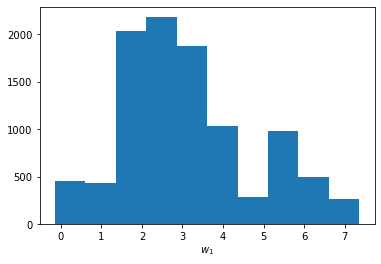

In [55]:
plt.hist(S[:,0], bins=10)
plt.xlabel("$w_1$");

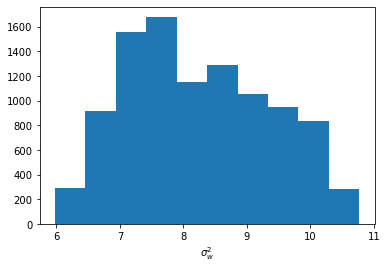

In [34]:
plt.hist(S[:,-2], bins=10)
plt.xlabel("$\sigma_w^2$");

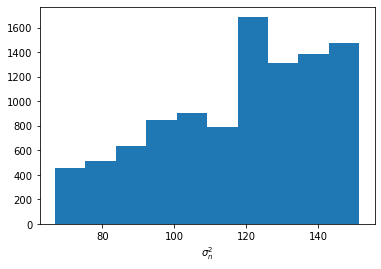

In [35]:
plt.hist(S[:,-1], bins=10)
plt.xlabel("$\sigma_n^2$");

In [36]:
w_opt = S[-1, :8]
sigma_w_2_opt = S[-1, -2]
sigma_n_2_opt = S[-1, -1]

In [50]:
w_mean_opt = np.mean(S[:,:8], axis=0)
sigma_w_2_mean_opt = np.mean(S[:,-2])
sigma_n_2_mean_opt = np.mean(S[:,-1])

In [54]:
print("Optimised:")
print("w =", w_mean_opt)
print("sigma_w_2 = {} sigma_n_2 = {}".format(sigma_w_2_mean_opt, sigma_n_2_mean_opt))

Optimised:
w = [ 3.11072934  1.91795832  2.98886479  0.69612967  7.59507772 -0.2827793
  2.60877943  0.38129564]
sigma_w_2 = 8.24911070560941 sigma_n_2 = 118.14196438226446


### Calculate gradient w and RMSE

In [38]:
# def get_w(X, y, sigma_n_2, sigma_w_2):
#     return np.linalg.inv(X.T@X + sigma_n_2*(1/sigma_w_2)*np.eye(X.shape[1]))@X.T@y

In [39]:
# w = get_w(X_train, y_train, sigma_n_2_opt, sigma_w_2_opt)
# w

In [40]:
y_intercept = y_train.mean()

In [52]:
y_test_pred = X_test@w_mean_opt + y_intercept

In [53]:
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print("test RMSE =", rmse_test)

test RMSE = 3.0757167780902264


In [43]:
def error_histogram(y_pred, y_targ):
    error_list = y_pred.reshape(-1, 1) - y_targ.reshape(-1, 1)
    plt.hist(error_list, bins=20)
    plt.xlabel("Error")
    plt.ylabel("Number of samples in the bin")
    plt.show()

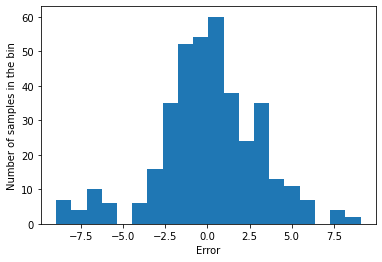

In [44]:
error_histogram(y_test_pred, y_test)